# 메모리 기반 추천시스템  / 모델 기반 추천시스템
## 1. 메모리 기반 : 추천을 위한 데이터를 모두 메모리에 갖고 있으면서 추천할때마다 데이터를 사용해서 계산 후 추천(ex. CF 알고리즘)
## 2. 데이터로부터 추천을 위한 모델을 구성 후 이 모델만 저장하고, 실제 추천시에는 이 모델을 써서 추천하는 방식(ex. MF 알고리즘, 딥러닝 알고리즘)
#### 메모리 기반 추천은 개별 사용자 데이터에 집중하는데 비해, 모델 기반 추천은 전체 사용자의 평가 패턴으로부터 모델을 구성하므로 데이터가 가진 약한 신호도 더 잘 잡는 특성 존재
#### 


### MF 알고리즘 : 행렬 요인화 방식
* R = P * Qt => ^R
* 관련 개념 교재 64p 참조
* 프로세스
* 1) 잠재요인 개수 K 구하기(변화시키면서 성능비교 또는 직관적으로 결정)
* 2) 주어진 K에 따라서 P행렬, Q행렬 구하기
* 3) P  Q 행렬을 연산하여 ^R구하기
* 4) test 데이터셋에서의 실제 평점 - ^R 값의 오차 계산
* 5) 오차를 줄이기 위해 P Q 값 수정
* 이후 3~5 반복


### SGD를 사용한 MF 알고리즘

In [1]:
import pandas as pd
import numpy as np
from google.colab import drive
drive.mount('/content/drive')

# df
r_cols = ['user_id','movie_id','rating','timestamp']
ratings = pd.read_csv('/content/drive/MyDrive/recomm_sample/u.data.csv',sep='\t',names=r_cols,
                      encoding='latin_1')

ratings_2 = ratings[['user_id','movie_id','rating']].astype(int)
ratings_2.head()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


,user_id,movie_id,rating
0,196,242,3
1,186,302,3
2,22,377,1
3,244,51,2
4,166,346,1


In [2]:
print(np.array(ratings_2))
print(np.shape(np.array(ratings_2)))
num_users, num_items = np.shape(np.array(ratings_2))
print(num_users,'\t',num_items)

[[ 196  242    3]
 [ 186  302    3]
 [  22  377    1]
 ...
 [ 276 1090    1]
 [  13  225    2]
 [  12  203    3]]
(100000, 3)
100000 	 3


In [3]:
# MF 계산 : train_test_split 없이 전체 다 넣고 한번에 계산

class MF():

  def __init__(self, ratings_2, k, alpha, beta, iterations, verbose=True):
    self.R = np.array(ratings_2)    # ratings_2 array형태로 변경
    self.num_users, self.num_items = np.shape(self.R)   # user수 / item 수 저장
    self.k = k
    self.alpha = alpha
    self.beta = beta
    self.iterations = iterations
    self.verbose = verbose

  def rmse(self):
    xs,ys = self.R.nonzero()  # self.R에서 평점이 있는(0이 없는) 요소의 인덱스 가져옴
    self.predictions = []
    self.errors = []
    for x,y in zip(xs,ys):
      prediction = self.get_prediction(x,y)
      self.predictions.append(prediction)
      self.errors.append(self.R[x,y] - prediction)
    
    self.predictions = np.array(self.predictions)
    self.errors = np.array(self.errors)
    return np.sqrt(np.mean(self.errors ** 2))

  
  def train(self):
    self.P = np.random.normal(scale=1./self.k, size=(self.num_users, self.k)) # P,Q 행렬을 맨 처음에는 평균0, 표준편차 1/k인 정규분포를 가진 난수로 초기화
    self.Q = np.random.normal(scale=1./self.k, size=(self.num_items, self.k))

    self.b_u = np.zeros(self.num_users) # 유저, 아이템에 대한 bias는 일단 0으로 초기화
    self.b_d = np.zeros(self.num_items) # 각각의 크기는 유저와 아이템 행렬 크기만큼 설정
    self.b = np.mean(self.R[self.R.nonzero()])  # 전체평균 b

    rows, columns = self.R.nonzero()    # R중에서 nonzero인 로우, 컬럼 가져옴
    self.samples = [(i, j, self.R[i,j]) for i,j in zip(rows,columns)]  # rows,columns를 리스트로 만듦 + 평점까지

    training_process = []
    for i in range(self.iterations):
      np.random.shuffle(self.samples)
      self.sgd()
      rmse = self.rmse()
      training_process.append((i+1,rmse))

      if self.verbose:    # verbose=True 일시 10번마다 학습횟수 & 오차 print
        if (i+1) % 10 == 0:
          print(f'Iteration : {i+1}     |    Train RMSE = {np.round(rmse,4)}')
    
    return training_process

  def get_prediction(self,i,j):
    prediction = self.b + self.b_u[i] + self.b_d[j] + self.P[i,:].dot(self.Q[j,:].T)
    return prediction
  
  def sgd(self):
    for i,j,r in self.samples:   # samples의 유저-아이템-평점에 대해
      prediction = self.get_prediction(i,j)
      e = (r - prediction)

      self.b_u[i] += self.alpha * (e - self.beta * self.b_u[i])   # b_u 업데이트
      self.b_d[j] += self.alpha * (e - self.beta * self.b_d[j])   # b_d 업데이트
      
      self.P[i,:] += self.alpha * (e*self.Q[j,:] - self.beta * self.P[i,:])  # P행렬 업데이트
      self.Q[j,:] += self.alpha * (e*self.P[i,:] - self.beta * self.Q[j,:])  # Q행렬 업데이트

R_temp = ratings_2.pivot(index='user_id',columns='movie_id',values='rating').fillna(0)
mf = MF(R_temp, k=30, alpha=0.001, beta=0.02, iterations=100, verbose=True)
train_process = mf.train()

Iteration : 10     |    Train RMSE = 0.9585
Iteration : 20     |    Train RMSE = 0.9373
Iteration : 30     |    Train RMSE = 0.9281
Iteration : 40     |    Train RMSE = 0.9225
Iteration : 50     |    Train RMSE = 0.9184
Iteration : 60     |    Train RMSE = 0.9147
Iteration : 70     |    Train RMSE = 0.9103
Iteration : 80     |    Train RMSE = 0.9044
Iteration : 90     |    Train RMSE = 0.896
Iteration : 100     |    Train RMSE = 0.8844


In [4]:
# train/test 데이터셋 분리
# 1) shuffle 함수 사용
from sklearn.utils import shuffle
train_size = 0.75
ratings_3 = shuffle(ratings_2, random_state=1)
cutoff = int(train_size * len(ratings_3))   # 75% 기준으로 train / test 데이터 분리
ratings_train = ratings_3.iloc[:cutoff]
ratings_test = ratings_3.iloc[cutoff:]

class mf_2():
    def __init__(self, ratings, k, alpha, beta, iterations, verbose=True):
        self.R = np.array(ratings)
    # user_id, item_id를 self.R의 인덱스와 매핑하기 위한 dictionary 생성
        item_id_index = []
        index_item_id = []
        for i, one_id in enumerate(ratings):
            item_id_index.append([one_id, i])
            index_item_id.append([i, one_id])
        self.item_id_index = dict(item_id_index)
        self.index_item_id = dict(index_item_id)        
        user_id_index = []
        index_user_id = []
        for i, one_id in enumerate(ratings.T):
            user_id_index.append([one_id, i])
            index_user_id.append([i, one_id])
        self.user_id_index = dict(user_id_index)
        self.index_user_id = dict(index_user_id)

        self.num_users, self.num_items = np.shape(self.R)
        self.k = k
        self.alpha = alpha
        self.beta = beta
        self.iterations = iterations
        self.verbose = verbose

    # train set의 RMSE 계산
    def rmse(self):
        xs, ys = self.R.nonzero()
        self.predictions = []
        self.errors = []
        for x, y in zip(xs, ys):
            prediction = self.get_prediction(x, y)
            self.predictions.append(prediction)
            self.errors.append(self.R[x, y] - prediction)
        self.predictions = np.array(self.predictions)
        self.errors = np.array(self.errors)
        return np.sqrt(np.mean(self.errors**2))

    # Ratings for user i and item j
    def get_prediction(self, i, j):
        prediction = self.b + self.b_u[i] + self.b_d[j] + self.P[i, :].dot(self.Q[j, :].T)
        return prediction

    # Stochastic gradient descent to get optimized P and Q matrix
    def sgd(self):
        for i, j, r in self.samples:
            prediction = self.get_prediction(i, j)
            e = (r - prediction)

            self.b_u[i] += self.alpha * (e - self.beta * self.b_u[i])
            self.b_d[j] += self.alpha * (e - self.beta * self.b_d[j])

            self.P[i, :] += self.alpha * (e * self.Q[j, :] - self.beta * self.P[i,:])
            self.Q[j, :] += self.alpha * (e * self.P[i, :] - self.beta * self.Q[j,:])

    # Test set을 선정
    def set_test(self, ratings_test):
        test_set = []
        for i in range(len(ratings_test)):      # test 데이터에 있는 각 데이터에 대해서
            x = self.user_id_index[ratings_test.iloc[i, 0]]     # 유저별 인덱스 x에 저장
            y = self.item_id_index[ratings_test.iloc[i, 1]]     # 아이템별 인덱스 y에 저장
            z = ratings_test.iloc[i, 2]       # 유저-아이템 평점 z에 저장
            test_set.append([x, y, z])
            self.R[x, y] = 0                    # Setting test set ratings to 0
        self.test_set = test_set
        return test_set                         # Return test set

    # Test set의 RMSE 계산
    def test_rmse(self):
        error = 0
        for one_set in self.test_set:
            predicted = self.get_prediction(one_set[0], one_set[1])
            error += pow(one_set[2] - predicted, 2)    # pow(a,b) : a의 b제곱 --> (one_set의 실제 평점 - 예측값)^2
        return np.sqrt(error/len(self.test_set))

    # Training 하면서 test set의 정확도를 계산
    def test(self):
        # Initializing user-feature and item-feature matrix
        self.P = np.random.normal(scale=1./self.k, size=(self.num_users, self.k))
        self.Q = np.random.normal(scale=1./self.k, size=(self.num_items, self.k))

        # Initializing the bias terms
        self.b_u = np.zeros(self.num_users)
        self.b_d = np.zeros(self.num_items)
        self.b = np.mean(self.R[self.R.nonzero()])

        # List of training samples
        rows, columns = self.R.nonzero()
        self.samples = [(i, j, self.R[i,j]) for i, j in zip(rows, columns)]

        # Stochastic gradient descent for given number of iterations
        training_process = []
        for i in range(self.iterations):
            np.random.shuffle(self.samples)
            self.sgd()
            rmse1 = self.rmse()
            rmse2 = self.test_rmse()
            training_process.append((i+1, rmse1, rmse2))
            if self.verbose:
                if (i+1) % 10 == 0:
                    print("Iteration: %d ; Train RMSE = %.4f ; Test RMSE = %.4f" % (i+1, rmse1, rmse2))
        return training_process

    # Ratings for given user_id and item_id
    def get_one_prediction(self, user_id, item_id):
        return self.get_prediction(self.user_id_index[user_id], self.item_id_index[item_id])

    # Full user-movie rating matrix
    def full_prediction(self):
        return self.b + self.b_u[:,np.newaxis] + self.b_d[np.newaxis,:] + self.P.dot(self.Q.T)

# Testing MF RMSE
R_temp = ratings_3.pivot(index='user_id', columns='movie_id', values='rating').fillna(0)
mf_train_test = mf_2(R_temp, k=30, alpha=0.001, beta=0.02, iterations=100, verbose=True)
test_set = mf_train_test.set_test(ratings_test)
result = mf_train_test.test()

Iteration: 10 ; Train RMSE = 0.9659 ; Test RMSE = 0.9834
Iteration: 20 ; Train RMSE = 0.9409 ; Test RMSE = 0.9645
Iteration: 30 ; Train RMSE = 0.9297 ; Test RMSE = 0.9566
Iteration: 40 ; Train RMSE = 0.9229 ; Test RMSE = 0.9523
Iteration: 50 ; Train RMSE = 0.9180 ; Test RMSE = 0.9495
Iteration: 60 ; Train RMSE = 0.9140 ; Test RMSE = 0.9476
Iteration: 70 ; Train RMSE = 0.9100 ; Test RMSE = 0.9461
Iteration: 80 ; Train RMSE = 0.9054 ; Test RMSE = 0.9445
Iteration: 90 ; Train RMSE = 0.8997 ; Test RMSE = 0.9428
Iteration: 100 ; Train RMSE = 0.8923 ; Test RMSE = 0.9405


In [5]:
item_id_index = []   
index_item_id = []
for i, one_id in enumerate(ratings_3):
  item_id_index.append([one_id,i])
  index_item_id.append([i,one_id])
print(item_id_index)
print(index_item_id)

[['user_id', 0], ['movie_id', 1], ['rating', 2]]
[[0, 'user_id'], [1, 'movie_id'], [2, 'rating']]


In [6]:
ratings_3

,user_id,movie_id,rating
43660,508,185,5
87278,518,742,5
14317,178,28,5
81932,899,291,4
95321,115,117,4
...,...,...,...
50057,26,840,2
98047,625,198,4
5192,56,568,4
77708,882,172,5


In [7]:
np.array(ratings_3)

array([[508, 185,   5],
       [518, 742,   5],
       [178,  28,   5],
       ...,
       [ 56, 568,   4],
       [882, 172,   5],
       [454, 140,   3]])

In [8]:
print(mf_train_test.full_prediction())   # 모든 유저의 모든 아이템에 대한 예측평점
print(mf_train_test.get_one_prediction(1, 2))   # 1번 유저의 2번 아이템에 대한 예측평점

[[3.81522928 3.41126336 3.06260518 ... 3.34986103 3.47508003 3.45565432]
 [3.93950074 3.48547443 3.15658192 ... 3.43476335 3.55562579 3.54793407]
 [3.2913347  2.90587883 2.54487344 ... 2.81669628 2.92879388 2.93179502]
 ...
 [4.1986998  3.78153435 3.42147583 ... 3.69423295 3.81681038 3.81957491]
 [4.38549108 3.89559176 3.56857356 ... 3.83298735 3.96175816 3.94567188]
 [3.81647432 3.40555918 3.00102443 ... 3.26856417 3.39538878 3.417957  ]]
3.4112633554328666


In [9]:
ratings_train

,user_id,movie_id,rating
43660,508,185,5
87278,518,742,5
14317,178,28,5
81932,899,291,4
95321,115,117,4
...,...,...,...
73044,751,399,3
94380,455,286,5
16494,429,1119,3
37067,412,172,5


In [ ]:
# 2) train_test_split 사용
from sklearn.model_selection import train_test_split
x = ratings_2.copy()
y = ratings_2['user_id']  
X_train,X_test,y_train,y_test = train_test_split(x,y,test_size=0.25,stratify=y) 

#### 추후 진행

In [10]:
# 최적의 K / iterations 값 찾기
# k값
# 일단 50~260까지 10단위로 끊은 후, 최적의 값을 보이는 10단위 수에서 +-1까지 수행
results = []
index = []
for k in range(50,261,10):
  print('k : ',k)
  R_temp = ratings_3.pivot(index='user_id',columns='movie_id',values='rating').fillna(0)
  mf_3 = mf_2(R_temp,k=k,alpha=0.001,beta=0.02,iterations=300,verbose=True)
  test_set = mf_3.set_test(ratings_test)
  result = mf_3.test()
  print(result)
  index.append(k)
  results.append(result)

k :  50
Iteration: 10 ; Train RMSE = 0.9661 ; Test RMSE = 0.9834
Iteration: 20 ; Train RMSE = 0.9414 ; Test RMSE = 0.9645
Iteration: 30 ; Train RMSE = 0.9305 ; Test RMSE = 0.9566
Iteration: 40 ; Train RMSE = 0.9241 ; Test RMSE = 0.9523
Iteration: 50 ; Train RMSE = 0.9197 ; Test RMSE = 0.9497
Iteration: 60 ; Train RMSE = 0.9164 ; Test RMSE = 0.9479
Iteration: 70 ; Train RMSE = 0.9134 ; Test RMSE = 0.9465
Iteration: 80 ; Train RMSE = 0.9103 ; Test RMSE = 0.9454
Iteration: 90 ; Train RMSE = 0.9068 ; Test RMSE = 0.9442
Iteration: 100 ; Train RMSE = 0.9022 ; Test RMSE = 0.9428
Iteration: 110 ; Train RMSE = 0.8960 ; Test RMSE = 0.9410
Iteration: 120 ; Train RMSE = 0.8878 ; Test RMSE = 0.9384
Iteration: 130 ; Train RMSE = 0.8771 ; Test RMSE = 0.9352
Iteration: 140 ; Train RMSE = 0.8640 ; Test RMSE = 0.9316
Iteration: 150 ; Train RMSE = 0.8491 ; Test RMSE = 0.9279
Iteration: 160 ; Train RMSE = 0.8325 ; Test RMSE = 0.9244
Iteration: 170 ; Train RMSE = 0.8144 ; Test RMSE = 0.9213
Iteration: 180 

In [11]:
# iterations값
summary = []
for i in range(len(results)):
  rmse = []
  for result in results[i]:
    rmse.append(result[2])  # rmse_2(테스트셋에 대한 rmse값)가 rmse에 append
  min = np.min(rmse)  # 각 iterations의 rmse 중 최소값 
  j = rmse.index(min)  # iteration 인덱스(횟수 값)
  summary.append([index[i], j+1, rmse[j]])   # summary에는 k값(50~260), 최적 iterations, 최적 RMSE값
print(summary)

[[50, 210, 0.9154285224431303], [60, 212, 0.9164148605119464], [70, 215, 0.9147217813611881], [80, 222, 0.9141788807845812], [90, 226, 0.9138964256592734], [100, 228, 0.9126541031578205], [110, 234, 0.9109163979519665], [120, 237, 0.9114373409573671], [130, 240, 0.9112095393715851], [140, 244, 0.9106123177045549], [150, 246, 0.9099953526694654], [160, 246, 0.9108234580832022], [170, 249, 0.9096453090800912], [180, 248, 0.9106724230781599], [190, 253, 0.9100150358153966], [200, 254, 0.9099988288815186], [210, 255, 0.9097240213955277], [220, 257, 0.9097971342781034], [230, 257, 0.9099663617450177], [240, 259, 0.9096223680971001], [250, 259, 0.9099926344993922], [260, 262, 0.9093942334680942]]


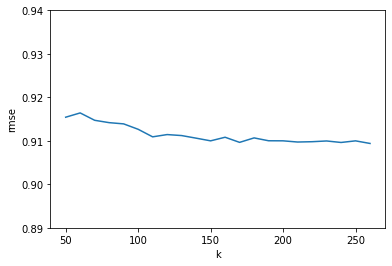

In [12]:
import matplotlib.pyplot as plt 
plt.plot(index , [x[2] for x in summary]) 
plt.ylim(0.89 , 0.94)
plt.xlabel('k')
plt.ylabel('rmse')
plt.show()